# 0. Instalação de Bibliotecas

In [116]:
import pandas as pd
import math
from numpy.random import rand
from numpy.random import seed
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import Bounds,  minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import random
import time
import os
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import requests
#from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier


#1 - Criando Conjunto de Dados Simulado

## 1.1 Função geradora do conjunto de dados: A função ***gera_data_frame*** retorna um conjunto de dados sintéticos de classificação, variando os parâmetros:
- número de observações no dataframe (linhas do conjunto de dados)
- número de variáveis preditoras (colunas do conjunto de dados)
- o limite do domínio das variáveis preditoras [1;inf)
- número de periodos (safras) em que as observações foram coletadas. (Obs: default = 30, para atender TCL)
- fator de desbalanceamento da target (default = 1, retorna um desbalanceamento na casa dos 70-30, em favor da classe 0). Valor do fator varia entre (0 ; 1.1]. Quanto mais próximo ao zero, mais balanceado (50-50), quanto mais próximo ao 1.1 mais desbalanceado(99.9-0.01) em favor da classe 0.

In [154]:
def gera_data_frame(n,p,m,q=None,d=1):
  #n = número de linhas do dataframe
  #p = número de variáveis preditoras
  #m = limite do domínio das variáveis preditoras, sendo o mínimo igual a 1
  #q = Número de safras temporais na base de dados (default é de 30 safras por TCL)
  #d = fator de desbalanceamento (default = 1, que retorna um desbalanceamento na casa dos 70-30) -> d varia entre (0 ; 1.1] (quanto mais próximo ao zero, mais balanceado, quanto mais próximo ao 1.1 mais desbalanceado)
  if q is None:
         q = n/30
  df = pd.DataFrame({'index':list(range(0,n))})
  import random
  for i in range(0,p):
    #w = random.randint(1,m)
    mu = random.randint(1,m)
    sigma = random.randint(1,m)
    w = np.random.normal(mu, sigma, n)
    df['v'+str(i)] = w
    #df['v'+str(i)] = random.choices(list(range(0, w)), k=n)
  df = df.drop(['index'],axis=1)
  vp_resposta=[]
  for z in range(0,n):
    numero_aleatorio = round(random.random())
    if (numero_aleatorio ==1) & (df.sum(axis=1)> ((df.sum(axis=1)).mean())*d)[z]:
      numero_aleatorio = 1
    else:
      numero_aleatorio = 0
    vp_resposta.append(numero_aleatorio)
  df['target'] = vp_resposta
  safras = (list(range(0,q))*int(n/q))
  safras.sort(reverse=False)
  safras = safras + [max(safras)]*(n - len(safras))
  df['safra'] = safras
  return df


### 1.1.1 Exemplo de Simulação com Dataframe de 1000 observações, 500 preditores com domínio até 200, distribuídos em 30 safras e desbalanceamento esperado na ordem de grandeza de 70-30.

In [155]:
df = gera_data_frame(1000,500,200,30,1)
df.shape

(1000, 502)

### 1.1.2 Desbalanceamento da Target

In [156]:
df.target.value_counts(normalize=True)

0    0.771
1    0.229
Name: target, dtype: float64

In [157]:
df.head(5)

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v492,v493,v494,v495,v496,v497,v498,v499,target,safra
0,-22.580211,51.961037,169.990305,-20.782870,315.229087,183.286611,99.697179,209.661327,-144.107448,48.747740,...,164.080012,166.178169,74.461418,139.582448,-7.538805,145.925693,145.331136,87.664898,0,0
1,-130.943426,150.064791,173.678878,-72.364610,261.166019,194.192539,64.619963,217.958003,-186.793915,46.427431,...,224.229164,69.076153,127.917154,24.121652,84.812883,205.948637,115.045416,11.608575,0,0
2,177.910872,374.233349,173.079742,-114.990727,502.081326,148.703385,129.652154,62.276915,64.098826,47.374331,...,94.212453,114.893164,85.227631,351.778641,-175.582960,-69.202101,125.519757,91.983098,0,0
3,392.675272,405.234311,171.686612,-40.840750,177.354747,156.072970,43.577052,89.911949,168.954230,45.101048,...,138.027374,260.670735,94.342614,277.165374,-16.702278,176.250904,115.493818,83.478794,0,0
4,326.436259,307.625807,174.179523,328.940092,70.983521,150.275086,-54.064235,165.512026,154.917140,46.337813,...,99.405504,62.561696,123.580637,231.751575,227.017681,121.665592,128.705664,35.135588,0,0


# 2. Desenvolvimento Método Proposto (Spearman-Markowitz-Clusterizado)

In [158]:
entrada_CSM = time.perf_counter()

## 2.1 Criação dos Grupos de Recursos (Via Coeficiente de Correlação de Spearman)

###2.1.1 Calculando a Correlação via Spearman e Pearson das Features em relação a variável resposta

In [159]:
#df.drop(['game_result'],axis=1).corr()
#df.corr(method= 'spearman')
target = 'target'
variaveis = df.columns.drop(['target','safra'])
correlacoes_p = []
correlacoes_s = []

for COLUNA in variaveis:
  correlacoes_p.append(np.round(df[target].corr(df[COLUNA]),2))
  correlacao, p = spearmanr(df[target], df[COLUNA])
  correlacoes_s.append(np.round(correlacao,2))
df_cor = pd.DataFrame({'Variaveis': variaveis, 'Correlacoes_S': correlacoes_s, 'Correlacoes_P': correlacoes_p})
#df_cor.sort_values(by=['Correlacoes'])
#df_cor.Correlacoes.min()
#df_cor.Correlacoes.max()
#df_cor.Correlacoes.quantile(q=0.75)
#df_cor.Correlacoes.quantile(q=0.25)
#df_cor.Correlacoes.quantile(q=0.5)


In [160]:
df_cor.sort_values(by=['Correlacoes_S'])

,Variaveis,Correlacoes_S,Correlacoes_P
373,v373,-0.07,-0.06
216,v216,-0.07,-0.06
268,v268,-0.06,-0.04
362,v362,-0.06,-0.04
55,v55,-0.06,-0.04
...,...,...,...
466,v466,0.09,0.09
447,v447,0.09,0.09
140,v140,0.09,0.10
325,v325,0.09,0.08


In [161]:
df_cor.sort_values(by=['Correlacoes_S'])['Correlacoes_S'].max(),df_cor.sort_values(by=['Correlacoes_S'])['Correlacoes_S'].min()

(0.09, -0.07)

### 2.1.2 Organizando as Features em grupos com base na similaridade de Correlação de Spearman

In [162]:
df_cor = df_cor.dropna()
df_cor['fx']= pd.qcut(df_cor['Correlacoes_P'], q=4)

lista_variaveis_fx = []
for i in list((range(0,len(pd.unique(df_cor['fx']))))):
  lista_variaveis_fx.append(df_cor[df_cor['fx']==pd.unique(df_cor['fx'])[i]].Variaveis)


tamanho_dos_grupos=[]
lista_de_grupos=[]
lista_variaveis_fx[0]
for i in list(range(0,len(lista_variaveis_fx))):
  lista_de_grupos.append('Grupo '+str(i))
  tamanho_dos_grupos.append(len(lista_variaveis_fx[i]))

divisao_grupos = pd.DataFrame({'Grupos':lista_de_grupos,'Tamanho do Grupo':tamanho_dos_grupos})
divisao_grupos


,Grupos,Tamanho do Grupo
0,Grupo 0,86
1,Grupo 1,151
2,Grupo 2,111
3,Grupo 3,152


####2.1.2.3 Quantidade de Variáveis Preditoras Selecionadas:

In [163]:
divisao_grupos['Tamanho do Grupo'].sum()

500

## 2.2 Ponderar a participação (importância) de cada Grupo de Recursos no treinamento do modelo (Via Teoria para Alocação de Portfólio de Markowitz)

### 2.2.1 Cálculo dos retornos (acurácia) dos grupos em cada safra

In [164]:
y = df['target']
X_vetor = []
X_vetor_train = []
X_vetor_test = []
y_vetor_train = []
y_vetor_test = []
for i in list(range(0,len(lista_variaveis_fx))):
  X_vetor.append('X_'+str(i+1))
  X_vetor_train.append('X_train_'+str(i+1))
  X_vetor_test.append('X_test_'+str(i+1))
  y_vetor_train.append('y_train_'+str(i+1))
  y_vetor_test.append('y_test_'+str(i+1))

for i in list(range(0,len(lista_variaveis_fx))):
  X_vetor[i] = df[lista_variaveis_fx[i]]
  X_vetor_train[i], X_vetor_test[i],y_vetor_train[i], y_vetor_test[i]= train_test_split(X_vetor[i], y, test_size = 0.3)

retorno_grupo = []
for i in list(range(0,len(X_vetor))):
  df_x = X_vetor[0]
  df_x['safra']=df['safra']
  df_x['target']=df['target']
  clf = lgb.LGBMClassifier()
  retorno_safra = []
  id_safra = []
  for ANO in pd.unique(df_x['safra']):
    df_xx = df_x[df_x.safra==ANO]
    x_filtrado = df_xx.drop(['safra','target'], axis = 1)
    y_filtrado = df_xx.target
    x_filtrado_train, x_filtrado_test, y_filtrado_train, y_filtrado_test= train_test_split(x_filtrado, y_filtrado, test_size = 0.3)
    clf.fit(x_filtrado_train, y_filtrado_train)
    pred_filtrado =clf.predict(x_filtrado_test)
    retorno_safra.append(accuracy_score(pred_filtrado, y_filtrado_test))
    id_safra.append(ANO)
  df_retornos = pd.DataFrame({'Retorno Grupo '+str(i): retorno_safra, 'Safra': id_safra})
  retorno_grupo.append(df_retornos)
df_retornos = reduce(lambda  left,right: pd.merge(left,right,on=['Safra'],how='outer'), retorno_grupo)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

In [165]:
first_column = df_retornos.pop('Safra')
df_retornos.insert(0, 'Safra', first_column)
df_retornos

,Safra,Retorno Grupo 0,Retorno Grupo 1,Retorno Grupo 2,Retorno Grupo 3
0,0,0.9,0.800000,0.800000,0.600000
1,1,0.9,1.000000,1.000000,0.800000
2,2,0.8,0.700000,0.600000,0.800000
3,3,0.6,0.800000,0.700000,0.700000
4,4,0.6,0.900000,0.700000,0.900000
5,5,0.8,0.900000,0.900000,0.600000
6,6,0.8,0.500000,0.700000,0.800000
7,7,0.8,0.800000,0.900000,1.000000
8,8,0.7,0.800000,0.700000,0.600000
9,9,0.4,0.500000,0.600000,0.600000


### 2.2.2 Construção da Fontreira eficiente (Risco vs Retorno). Em que, o risco é a variabilidade da acurácia.

In [166]:
#Cálculo do retorno do portifolio
def get_portfolio_returns(returns, weights):
    return np.dot(returns.mean(), weights)
#Cálculo do risco do portifólio, considerando o desvio padrão
def get_portfolio_risk(returns, weights):
    covariances = returns.cov()
    var_risk = np.matmul(np.matmul((weights), covariances.values), weights)
    std_risk = np.sqrt(var_risk)
    return std_risk
def mount_portfolio(x , args):
    return get_portfolio_risk(args, x)
def compute_frontier(returns_range, returns_df):
    optimal_portfolios = []
    #restrição para que a soma dos pesos não ultrapasse o valor 1
    eq_constraint_proportions = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
    #definição dos limites inferior e superior dos pesos em 0 e 1, respectivamente
    bounds = Bounds(ub=[1,1,1,1], lb=[0,0,0,0])


    #ponto de paprtida para o algoritmo de otimização, foram utilizados pesos igualmente distribuídos
    initial_guess = np.ones(len(returns_df.columns))*1/len(returns_df.columns)
    for value in returns_range:
        #restrição para garantir que o valor de retorno desejado será mantido
        eq_constraint_return = {'type':'eq', 'fun': lambda x : get_portfolio_returns(returns_df, x) - value}

        optimal_weights = minimize(mount_portfolio, x0 = initial_guess, method = 'SLSQP',
                constraints = [eq_constraint_proportions, eq_constraint_return],
                bounds=bounds,  options={'ftol':1e-9, 'disp':False},
                args = (returns_df,))
        optimal_portfolios.append(optimal_weights)

    return optimal_portfolios


In [167]:
#Definição dos patamares de retorno máximo e mínimo
real_returns = df_retornos.drop(['Safra'],axis=1)
min_return = real_returns.mean().min()
max_return = real_returns.mean().max()
def generate_random_portfolios(num_samples, returns):
    returns_from_random_weights = []
    risks_from_random_weights = []
    weights = []
    for i in range(0, num_samples):
        random_weights = np.random.rand(len(returns.columns))
        random_weights = random_weights/np.sum(random_weights)
        weights.append(random_weights)

        random_return = get_portfolio_returns(returns, random_weights)
        random_risk = get_portfolio_risk(returns, random_weights)

        returns_from_random_weights.append(random_return)
        risks_from_random_weights.append(random_risk)
    return [risks_from_random_weights, returns_from_random_weights, weights]

Text(0.5, 0, 'Risco')

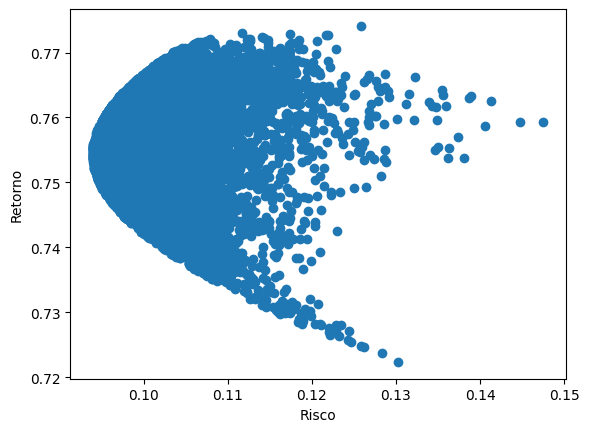

In [168]:
random_ports = generate_random_portfolios(10000, real_returns)
plt.scatter(random_ports[0], random_ports[1])
plt.ylabel('Retorno')
plt.xlabel('Risco')

### 2.2.3 Definição dos pesos de participação de cada grupo no processo de modelagem, a partir de um critério de alocação ótima (Ex: maior retorno possível no menor risco).

In [169]:
fronteira_eficiente = pd.DataFrame({'Risco':random_ports[0],'Retorno':random_ports[1], 'Pesos':random_ports[2]})
fronteira_eficiente['Pesos'] = fronteira_eficiente.Pesos.apply(lambda x: np.round(x, 2))

#### 2.2.3.1 Binômio Risco-Retorno Ótimo (obs: Critério de variabilidade mínima, ou risco mínimo)

In [170]:
alocacao_otima = fronteira_eficiente[fronteira_eficiente.Risco ==fronteira_eficiente.Risco.min()]
alocacao_otima[['Risco','Retorno']]

,Risco,Retorno
4399,0.093948,0.754353


#### 2.2.3.1 Distribuição do Índice de Importância de cada Grupo (Qual a porcentagem de features contidas em cada grupo deve participar do processo de treinamento do modelo)

In [171]:
alocacao_otima.Pesos

4399    [0.27, 0.08, 0.35, 0.3]
Name: Pesos, dtype: object

## 2.3 Redução aleatória dentro de cada Grupo de Features (respeitando o índice de Importância encontrado na etapa anterior).

In [172]:
divisao_grupos['Alocacao Otima'] = alocacao_otima.Pesos.values[0]
divisao_grupos['Tamanho Final do Grupo'] = round((divisao_grupos['Tamanho do Grupo']*divisao_grupos['Alocacao Otima'])/divisao_grupos['Alocacao Otima'].sum(),0)
divisao_grupos

,Grupos,Tamanho do Grupo,Alocacao Otima,Tamanho Final do Grupo
0,Grupo 0,86,0.27,23.0
1,Grupo 1,151,0.08,12.0
2,Grupo 2,111,0.35,39.0
3,Grupo 3,152,0.30,46.0


In [173]:
print('Número final de váriaveis: ',divisao_grupos['Tamanho Final do Grupo'].sum()),
print('Isso equivale à ',100*(round(1 -(divisao_grupos['Tamanho Final do Grupo'].sum()/divisao_grupos['Tamanho do Grupo'].sum()),2)),'% de redução no volume das variáveis inicias')

Número final de váriaveis:  120.0
Isso equivale à  76.0 % de redução no volume das variáveis inicias


In [174]:
variaveis_filtradas_csm = []
for i in list(range(0,len(X_vetor))):
  df_x = X_vetor[i]
  df_x = df_x.drop(['safra','target'],axis=1,errors='ignore')
  df_x = df_x.sample(n=int(divisao_grupos['Tamanho Final do Grupo'][i]),axis='columns')
  #df_x = df_x.sample(n=math.ceil(divisao_grupos['Alocacao Otima'][i]*df_x.shape[1]),axis='columns')
  variaveis_filtradas_csm.extend(df_x.columns)

In [175]:
saida_CSM = time.perf_counter()
tempo_CSM = saida_CSM - entrada_CSM
'O Projeto levou '+str(round(tempo_CSM,0))+' segundos para rodar até essa fase.'

'O Projeto levou 20.0 segundos para rodar até essa fase.'

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# 3. Implantação de Métodos Desafiantes:
- Método de Filtragem por Informação Mútua
- Método *Embedded* por Algorítmo ExtraTrees
- Método Híbrido combinando Informação Mútua e Extratrees

## 3.1 Método de Seleção Embedded via Algoritmo de Árvores Extremamente Aleatórias (ExtraTrees)

In [176]:
entrada_ExtraTrees = time.perf_counter()
def funcao_variaveis_importantes(DADOS,varesp = 'y'):
        DADOS = DADOS.drop(['safra'], axis=1)
        X = DADOS.loc [:, DADOS.columns != varesp]
        Y = DADOS.loc [:, DADOS.columns == varesp]
        warnings.filterwarnings("ignore")
        model = ExtraTreesClassifier()
        model.fit(X,Y)
        ind = X.shape[1]
        variaveis = X.columns[0:ind]
        importancia = pd.DataFrame(variaveis)
        features = pd.DataFrame(model.feature_importances_)
        importancia['Importancia']= features
        importancia = importancia.rename(columns = {0:"Variáveis","Importancia":"Importancia"})
        return importancia.sort_values(['Importancia'], ascending=False)

lista_vp_ExtraTrees = funcao_variaveis_importantes(df,varesp = 'target')
X_filtrado_ExtraTrees = df[lista_vp_ExtraTrees[lista_vp_ExtraTrees.Importancia>0]['Variáveis'].values] #Importância maior que zero
lista_vp_filtrada_ExtraTrees = X_filtrado_ExtraTrees.columns
saida_ExtraTrees = time.perf_counter()
tempo_ExtraTrees = saida_ExtraTrees - entrada_ExtraTrees
'O algoritmo levou '+str(round(tempo_ExtraTrees,0))+' segundos para rodar e deixou '+str(len(lista_vp_filtrada_ExtraTrees))+' variáveis preditoras.'

'O algoritmo levou 1.0 segundos para rodar e deixou 500 variáveis preditoras.'

## 3.2 Método de Seleção por Filtro via  Informação Mútua

In [177]:
entrada_MI = time.perf_counter()
variaveis = df.columns.drop(['target','safra'])
X_train_mutual_info, X_test_mutual_info,y_train_mutual_info, y__test_mutual_info= train_test_split(df[variaveis], df[target].to_numpy(), test_size = 0.3)
mutual_info = mutual_info_classif(X_train_mutual_info, y_train_mutual_info)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_mutual_info.columns
lista_vp_filtrada_MI = mutual_info[mutual_info.sort_values(ascending=False)>0] #Ganho de Informação maior que zero
saida_MI = time.perf_counter()
tempo_MI = saida_MI - entrada_MI
'O algoritmo levou '+str(round(tempo_MI,0))+' segundos para rodar e deixou '+str(len(lista_vp_filtrada_MI))+' variáveis preditoras.'

'O algoritmo levou 2.0 segundos para rodar e deixou 235 variáveis preditoras.'

## 3.3 Método Combinado de Seleção (Informação Mutua e ExtraTrees)

In [178]:
entrada_COMBINADO = time.perf_counter()
df_combinado = df[lista_vp_filtrada_MI.index]
df_combinado['target'] = df.target
def funcao_variaveis_importantes(DADOS,varesp = 'y'):
        X = DADOS.loc [:, DADOS.columns != varesp]
        Y = DADOS.loc [:, DADOS.columns == varesp]
        warnings.filterwarnings("ignore")
        model = ExtraTreesClassifier()
        model.fit(X,Y)
        ind = X.shape[1]
        variaveis = X.columns[0:ind]
        importancia = pd.DataFrame(variaveis)
        features = pd.DataFrame(model.feature_importances_)
        importancia['Importancia']= features
        importancia = importancia.rename(columns = {0:"Variáveis","Importancia":"Importancia"})
        return importancia.sort_values(['Importancia'], ascending=False)

lista_vp_COMBINADO = funcao_variaveis_importantes(df_combinado,varesp = 'target')
X_filtrado_COMBINADO = df_combinado[lista_vp_COMBINADO[lista_vp_COMBINADO.Importancia>0]['Variáveis'].values] #Importância maior que zero
lista_vp_filtrada_COMBINADO = X_filtrado_COMBINADO.columns
saida_COMBINADO = time.perf_counter()
tempo_COMBINADO = saida_COMBINADO - entrada_COMBINADO
'O algoritmo levou '+str(round(tempo_COMBINADO,0))+' segundos para rodar e deixou '+str(len(lista_vp_filtrada_COMBINADO))+' variáveis preditoras.'

'O algoritmo levou 0.0 segundos para rodar e deixou 235 variáveis preditoras.'

# 4. Comparação do Desempenho dos Algoritmos: Análise se a exclusão de features resultou em perda significativa de performance.
- Modelo construído com a base completa (Sem processo de seleção de feature)
- Modelo construído com a base selecionada a partir do Método de Informação Mútua
- Modelo construído com a base selecionada a partir do Método de Seleção ExtraTrees
- Modelo construído com base selecionada a partir da combinação entre Informação Mutua e ExtraTrees
- Modelo construído com base selecionada a partir do Método Proposto (Spearman-Markowitz Clusterizado)

Obs: Para evitar viés do algoritmo, todos os modelos foram criados a partir do algoritmo LightGBM

## 4.1 Acurácia estimada a partir de Modelo construído com a Base Completa

In [179]:
  entrada_FULL = time.perf_counter()
  X_train, X_test,y_train, y__test= train_test_split(df[variaveis], df[target], test_size = 0.3)
  clf = lgb.LGBMClassifier()
  clf.fit(X_train, y_train)
  predicao = clf.predict(X_test)
  acuracia_total_FULL = accuracy_score(predicao, y__test)
  saida_FULL = time.perf_counter()
  tempo_FULL = saida_FULL - entrada_FULL
  'O algoritmo levou '+str(round(tempo_FULL,0))+' segundos para rodar um modelo com todas as variáveis preditoras, obtedo uma acurácia de '+ str(round(acuracia_total_FULL,3))+'.'

[LightGBM] [Info] Number of positive: 159, number of negative: 541
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116870
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227143 -> initscore=-1.224515
[LightGBM] [Info] Start training from score -1.224515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

'O algoritmo levou 4.0 segundos para rodar um modelo com todas as variáveis preditoras, obtedo uma acurácia de 0.763.'

##4.2 Acurácia estimada a partir de Modelo construído com a base selecionada a partir do Método de Informação Mútua

In [180]:
entrada_MI_model= time.perf_counter()
sel_cols = SelectKBest(mutual_info_classif, k=len(lista_vp_filtrada_MI))
sel_cols.fit(X_train_mutual_info, y_train_mutual_info)
X_filtrado = df[X_train_mutual_info.columns[sel_cols.get_support()]]
X_train, X_test,y_train, y_test= train_test_split(X_filtrado, df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
predicao = clf.predict(X_test)
acuracia_total_MI_model = accuracy_score(predicao, y_test)
saida_MI_model = time.perf_counter()
tempo_MI_model = saida_MI_model - entrada_MI_model
'O processo de Modelagem levou '+str(round(tempo_MI_model,0))+' segundos para rodar com '+str(len(lista_vp_filtrada_MI))+' variáveis preditoras, resultando em uma acurácia de '+ str(round(acuracia_total_MI_model,3))+'.'


[LightGBM] [Info] Number of positive: 154, number of negative: 546
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54926
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220000 -> initscore=-1.265666
[LightGBM] [Info] Start training from score -1.265666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

'O processo de Modelagem levou 5.0 segundos para rodar com 235 variáveis preditoras, resultando em uma acurácia de 0.75.'

## 4.3 Acurácia estimada a partir de Modelo construído com a base selecionada a partir do Método *Embedeed* via Algoritmo de Árvores Extremamente Aleatórias.

In [181]:
entrada_ExtraTree_Model = time.perf_counter()

X_train, X_test,y_train, y_test= train_test_split(X_filtrado_ExtraTrees, df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
predicao = clf.predict(X_test)
acuracia_ExtraTree_Model = accuracy_score(predicao, y_test)
saida_ExtraTree_Model = time.perf_counter()
tempo_ExtraTree_Model = saida_ExtraTree_Model - entrada_ExtraTree_Model
'O processo de Modelagem levou '+str(round(tempo_ExtraTree_Model,0))+' segundos para rodar com '+str(len(lista_vp_filtrada_ExtraTrees))+' variáveis preditoras, resultando em uma acurácia de '+ str(round(acuracia_ExtraTree_Model,3))+'.'


[LightGBM] [Info] Number of positive: 162, number of negative: 538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116881
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231429 -> initscore=-1.200262
[LightGBM] [Info] Start training from score -1.200262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

'O processo de Modelagem levou 4.0 segundos para rodar com 500 variáveis preditoras, resultando em uma acurácia de 0.777.'

## 4.4 Acurácia estimada a partir de Modelo construído com a base selecionada a partir do Método combinado entre a Informação Mútua e o Algoritmo de Árvores Extremamente Aleatórias.

In [182]:
entrada_combinado_Model = time.perf_counter()

X_train, X_test,y_train, y_test= train_test_split(X_filtrado_COMBINADO, df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
predicao = clf.predict(X_test)
acuracia_combinado_Model = accuracy_score(predicao, y_test)
saida_combinado_Model = time.perf_counter()
tempo_combinado_Model = saida_combinado_Model - entrada_combinado_Model
'O processo de Modelagem levou '+str(round(tempo_combinado_Model,0))+' segundos para rodar com '+str(len(lista_vp_filtrada_ExtraTrees))+' variáveis preditoras, resultando em uma acurácia de '+ str(round(acuracia_combinado_Model,3))+'.'


[LightGBM] [Info] Number of positive: 163, number of negative: 537
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54929
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232857 -> initscore=-1.192248
[LightGBM] [Info] Start training from score -1.192248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

'O processo de Modelagem levou 2.0 segundos para rodar com 500 variáveis preditoras, resultando em uma acurácia de 0.777.'

## 4.5 Acurácia estimada a partir de Modelo construído com a base selecionada a partir do Método Spearman-Markowitz Clusterizado.

In [183]:
entrada_CSM_model = time.perf_counter()
X_train_final, X_test_final,y_train_final, y_test_final= train_test_split(df[variaveis_filtradas_csm], df[target], test_size = 0.3)
clf = lgb.LGBMClassifier()
clf.fit(X_train_final, y_train_final)
predicao = clf.predict(X_test_final)
acuracia_CSM_model = accuracy_score(predicao, y_test_final)
saida_CSM_model = time.perf_counter()
tempo_CSM_model = saida_CSM_model - entrada_CSM_model
'A proposta levou '+str(round(tempo_CSM_model,0))+' segundos para rodar com '+str(len(variaveis_filtradas_csm))+' variáveis preditoras, resultando em uma acurácia de '+ str(round(acuracia_CSM_model,3))+'.'

[LightGBM] [Info] Number of positive: 162, number of negative: 538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28046
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231429 -> initscore=-1.200262
[LightGBM] [Info] Start training from score -1.200262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

'A proposta levou 1.0 segundos para rodar com 120 variáveis preditoras, resultando em uma acurácia de 0.77.'

# 5. Tabela Resumo de desempenhos:


In [184]:
Metodo_de_Seleção = ['Sem Seleção','Informação Mutua', 'ExtraTrees','Combinado', 'CSM']
N_features = [df.shape[1]-2,len(lista_vp_filtrada_MI),len(lista_vp_filtrada_ExtraTrees),len(lista_vp_filtrada_COMBINADO),len(variaveis_filtradas_csm)]
Performance = [round(acuracia_total_FULL,3),round(acuracia_total_MI_model,3),round(acuracia_ExtraTree_Model,3),round(acuracia_combinado_Model,3),round(acuracia_CSM_model,3)]
Tempo_modelagem = [round(tempo_FULL,3),round(tempo_MI_model,3),round(tempo_ExtraTree_Model,3),round(tempo_combinado_Model,3),round(tempo_CSM_model,3)]
Tempo_selecao = [0,round(tempo_MI,3),round(tempo_ExtraTrees,3),round(tempo_COMBINADO,3),round(tempo_CSM,3)]

resultados = pd.DataFrame({'Métodos de Seleção':Metodo_de_Seleção,'N° de Features':N_features,'Acurácia do Modelo Final':Performance,
              'Tempo de Treinamento do Modelo':Tempo_modelagem,'Tempo do Processamento da Seleção de Feat.':Tempo_selecao})

resultados.sort_values(by=['Acurácia do Modelo Final'], ascending=False)

,Métodos de Seleção,N° de Features,Acurácia do Modelo Final,Tempo de Treinamento do Modelo,Tempo do Processamento da Seleção de Feat.
2,ExtraTrees,500,0.777,4.460,0.523
3,Combinado,235,0.777,1.974,0.363
4,CSM,120,0.770,0.951,20.075
0,Sem Seleção,500,0.763,4.085,0.000
1,Informação Mutua,235,0.750,4.562,2.181
